# Prediction after a pulmonary embolism

## Importing and preparing the data

In [49]:
import json
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score


warnings.filterwarnings('ignore')
pd.set_option('display.max_row', 1574)
pd.set_option('display.max_column', 111)


# We open the data as a pandas DataFrame

with open('atle_dataset.json') as f:
    data = json.load(f)

dic_train = data['train']
dic_test = data['test']

train = pd.DataFrame.from_dict(dic_train)
test = pd.DataFrame.from_dict(dic_test)

data = pd.concat([train, test])

trainset = train.copy()
testset = test.copy()


# We replace a boolean variable with a bilateral variable

trainset['PESI_Cancertidligereelleraktiv'] = trainset['PESI_Cancertidligereelleraktiv'].replace([True, False],[1,0])
testset['PESI_Cancertidligereelleraktiv'] = testset['PESI_Cancertidligereelleraktiv'].replace([True, False],[1,0])

# We drop NaN from the train set

trainset = trainset.fillna(0)
testset = testset.fillna(0)

# We drop the variable we don't need

trainset_dod = trainset.drop(['ACOinnen30dager', 'Combined_outcome'], axis=1)
trainset_aco = trainset.drop(['Dødinnen30dager', 'Combined_outcome'], axis=1)
trainset_co = trainset.drop(['Dødinnen30dager', 'ACOinnen30dager'], axis=1)

testset_dod = testset.drop(['ACOinnen30dager', 'Combined_outcome'], axis=1)
testset_aco = testset.drop(['Dødinnen30dager', 'Combined_outcome'], axis=1)
testset_co = testset.drop(['Dødinnen30dager', 'ACOinnen30dager'], axis=1)

# We create X, y for train and test

X_dod = trainset_dod.drop(['Dødinnen30dager'], axis=1)
y_dod = trainset_dod['Dødinnen30dager']
X_test_dod = testset_dod.drop(['Dødinnen30dager'], axis=1)
y_test_dod = testset_dod['Dødinnen30dager']

X_aco = trainset_aco.drop(['ACOinnen30dager'], axis=1)
y_aco = trainset_aco['ACOinnen30dager']
X_test_aco = testset_aco.drop(['ACOinnen30dager'], axis=1)
y_test_aco = testset_aco['ACOinnen30dager']

X_co = trainset_co.drop(['Combined_outcome'], axis=1)
y_co = trainset_co['Combined_outcome']
X_test_co = testset_co.drop(['Combined_outcome'], axis=1)
y_test_co = testset_co['Combined_outcome']

data.head()

,TidligereDVT,Tidligerelungeemboli,RVLVratio,pCO2vedarteriellblodgass,pO2vedarteriellblodgass,SpO2vedperifermåling,PESI_DiastoliskBT,PESI_SystoliskBT,PESI_Pulsvedinnkomst,PESI_SpO290,PESI_Påvirketmentalstatus,PESI_Temp36,PESI_Resprate30,PESI_SystoliskBT100mmHg,PESI_Hjertefrekvens110,PESI_Kronisklungesykdom,PESI_Hjertesvikt,PESI_Cancertidligereelleraktiv,Ddimer,TroponinIT,SumCharlsonComorbidityIndex,malefemale,MBPEC,CCI_sum,Bilateral,Sentral,Age_years,Dødinnen30dager,ACOinnen30dager,Combined_outcome
0,0.0,0.0,-0.606951,-0.554742,-0.511012,0.142411,-0.012365,-0.493722,0.058545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,-0.914122,NaN,0.431301,1.0,-1.544871,0.560199,0.0,0.0,0.819234,0,0,0
1,0.0,1.0,0.756011,0.092491,-1.148042,-0.005647,-1.338116,0.104106,-1.886243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,-0.035762,NaN,0.913451,0.0,1.104205,0.793343,1.0,1.0,1.184352,0,0,0
2,0.0,0.0,0.343952,NaN,NaN,0.882697,2.134088,2.275166,0.204404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.317822,-0.241998,-0.533000,0.0,1.104205,0.093910,1.0,1.0,-0.093560,0,0,0
3,0.0,0.0,0.343952,-0.568513,0.170809,0.142411,1.313385,1.142439,2.246431,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,-0.498141,NaN,-1.015150,0.0,1.104205,-1.538103,1.0,1.0,-1.188914,0,0,0
4,0.0,0.0,2.150669,-0.293095,-0.227334,-0.449819,-0.328020,-0.934227,0.641981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,1.485769,NaN,-0.533000,1.0,1.104205,0.093910,1.0,1.0,-0.032707,0,0,0


## Importing and optimizing the models

In [69]:
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold

In [10]:
X_list = [X_dod, X_aco, X_co]
y_list = [y_dod, y_aco, y_co]
n_model = ['Dødinnen30dager', 'ACOinnen30dager', 'Combined_outcome']

n_e = [100, 1000]
l_r = [0.01, 0.1]

print('-'*30, 'ADABOOST', '-'*30,'\n')
for x, y, n in zip(X_list, y_list, n_model):
    hyperparams = []
    scores = []
    for i in n_e:
        for j in l_r:
            hyperparams.append((i,j))
            model = AdaBoostRegressor(n_estimators=i, learning_rate=j, random_state=0)
            model.fit(x, y)     
            cv_scores = cross_val_score(model, x, y, scoring='roc_auc', cv=10)
            scores.append(cv_scores.mean())
    best_param = [(hyperparams, round(score, 2)) for hyperparams, score in zip(hyperparams, scores)]
    best_param = sorted(best_param, key = lambda x: x[1], reverse = True)
    print(n, ':')
    print(' '*50)
    [print('Hyperparameters: {} \t\t CV_Score: {}'.format(*i)) for i in best_param];
    print('-'*80 ,'\n')

------------------------------ ADABOOST ------------------------------ 

Dødinnen30dager :
                                                  
Hyperparameters: (1000, 0.01) 		 CV_Score: 0.76
Hyperparameters: (100, 0.01) 		 CV_Score: 0.75
Hyperparameters: (100, 0.1) 		 CV_Score: 0.75
Hyperparameters: (1000, 0.1) 		 CV_Score: 0.75
-------------------------------------------------------------------------------- 

ACOinnen30dager :
                                                  
Hyperparameters: (100, 0.01) 		 CV_Score: 0.81
Hyperparameters: (100, 0.1) 		 CV_Score: 0.81
Hyperparameters: (1000, 0.01) 		 CV_Score: 0.81
Hyperparameters: (1000, 0.1) 		 CV_Score: 0.81
-------------------------------------------------------------------------------- 

Combined_outcome :
                                                  
Hyperparameters: (100, 0.1) 		 CV_Score: 0.77
Hyperparameters: (1000, 0.01) 		 CV_Score: 0.77
Hyperparameters: (1000, 0.1) 		 CV_Score: 0.77
Hyperparameters: (100, 0.01) 		 CV_S

In [27]:
X_list = [X_dod, X_aco, X_co]
y_list = [y_dod, y_aco, y_co]
n_model = ['Dødinnen30dager', 'ACOinnen30dager', 'Combined_outcome']

n_e = [10, 100, 1000]
m_d = [3, 4, 5]

print('-'*30, 'RANDOMFOREST', '-'*30,'\n')
for x, y, n in zip(X_list, y_list, n_model):
    hyperparams = []
    scores = []
    for i in n_e:
        for j in m_d:
            hyperparams.append((i,j))
            model = RandomForestRegressor(n_estimators=i, max_depth=j, random_state=0)
            model.fit(x, y)     
            cv_scores = cross_val_score(model, x, y, scoring='roc_auc', cv=10)
            scores.append(cv_scores.mean())
    best_param = [(hyperparams, round(score, 3)) for hyperparams, score in zip(hyperparams, scores)]
    best_param = sorted(best_param, key = lambda x: x[1], reverse = True)
    print(n, ':')
    print(' '*50)
    [print('Hyperparameters: {} \t\t CV_Score: {}'.format(*i)) for i in best_param];
    print('-'*80 ,'\n')

------------------------------ RANDOMFOREST ------------------------------ 

Dødinnen30dager :
                                                  
Hyperparameters: (100, 4) 		 CV_Score: 0.761
Hyperparameters: (1000, 4) 		 CV_Score: 0.761
Hyperparameters: (1000, 5) 		 CV_Score: 0.759
Hyperparameters: (100, 5) 		 CV_Score: 0.758
Hyperparameters: (1000, 3) 		 CV_Score: 0.758
Hyperparameters: (100, 3) 		 CV_Score: 0.757
Hyperparameters: (10, 3) 		 CV_Score: 0.736
Hyperparameters: (10, 4) 		 CV_Score: 0.717
Hyperparameters: (10, 5) 		 CV_Score: 0.714
-------------------------------------------------------------------------------- 

ACOinnen30dager :
                                                  
Hyperparameters: (100, 5) 		 CV_Score: 0.832
Hyperparameters: (1000, 4) 		 CV_Score: 0.832
Hyperparameters: (1000, 5) 		 CV_Score: 0.832
Hyperparameters: (1000, 3) 		 CV_Score: 0.828
Hyperparameters: (100, 4) 		 CV_Score: 0.817
Hyperparameters: (10, 5) 		 CV_Score: 0.816
Hyperparameters: (10, 4) 

In [29]:
X_list = [X_dod, X_aco, X_co]
y_list = [y_dod, y_aco, y_co]
n_model = ['Dødinnen30dager', 'ACOinnen30dager', 'Combined_outcome']

gamma = [1e-5, 1e-6, 1e-7]
C = [0.1, 1]

print('-'*30, 'SVM', '-'*30,'\n')
for x, y, n in zip(X_list, y_list, n_model):
    hyperparams = []
    scores = []
    for i in gamma:
        for j in C:
            hyperparams.append((i,j))
            model = SVR(gamma=i, C=j)
            model.fit(x, y)     
            cv_scores = cross_val_score(model, x, y, scoring='roc_auc', cv=10)
            scores.append(cv_scores.mean())
    best_param = [(hyperparams, round(score, 3)) for hyperparams, score in zip(hyperparams, scores)]
    best_param = sorted(best_param, key = lambda x: x[1], reverse = True)
    print(n, ':')
    print(' '*50)
    [print('Hyperparameters: {} \t\t CV_Score: {}'.format(*i)) for i in best_param];
    print('-'*80 ,'\n')

------------------------------ SVM ------------------------------ 

Dødinnen30dager :
                                                  
Hyperparameters: (1e-05, 0.1) 		 CV_Score: 0.775
Hyperparameters: (1e-06, 0.1) 		 CV_Score: 0.773
Hyperparameters: (1e-06, 1) 		 CV_Score: 0.773
Hyperparameters: (1e-07, 0.1) 		 CV_Score: 0.77
Hyperparameters: (1e-07, 1) 		 CV_Score: 0.769
Hyperparameters: (1e-05, 1) 		 CV_Score: 0.632
-------------------------------------------------------------------------------- 

ACOinnen30dager :
                                                  
Hyperparameters: (1e-05, 0.1) 		 CV_Score: 0.737
Hyperparameters: (1e-06, 1) 		 CV_Score: 0.735
Hyperparameters: (1e-06, 0.1) 		 CV_Score: 0.734
Hyperparameters: (1e-07, 0.1) 		 CV_Score: 0.73
Hyperparameters: (1e-07, 1) 		 CV_Score: 0.729
Hyperparameters: (1e-05, 1) 		 CV_Score: 0.669
-------------------------------------------------------------------------------- 

Combined_outcome :
                                   

In [70]:
X_list = [X_dod, X_aco, X_co]
y_list = [y_dod, y_aco, y_co]
n_model = ['Dødinnen30dager', 'ACOinnen30dager', 'Combined_outcome']

max_depth = [4]
alpha = [5, 6, 7]
n_estimators = [500]
learning_rate = [0.2]
colsample_bytree = [0.2]

print('-'*30, 'XGBoost', '-'*30,'\n')
for x, y, n in zip(X_list, y_list, n_model):
    hyperparams = []
    scores = []
    for i in max_depth:
        for j in alpha:
            for k in n_estimators:
                for l in learning_rate:
                    for m in colsample_bytree:      
                        hyperparams.append((i,j,k,l,m))
                        model = XGBRegressor(objective='binary:logistic', max_depth=i, alpha=j, n_estimators=k, learning_rate=l, colsample_bytree=m, verbosity=0, random_state=0)
                        model.fit(x, y)
                        kfold = KFold(n_splits=10, shuffle=True)
                        cv_scores = cross_val_score(model, x, y, scoring='roc_auc', cv=kfold)
                        scores.append(cv_scores.mean())
    best_param = [(hyperparams, round(score, 3)) for hyperparams, score in zip(hyperparams, scores)]
    best_param = sorted(best_param, key = lambda x: x[1], reverse = True)
    print(n, ':')
    print(' '*50)
    [print('Hyperparameters: {} \t\t CV_Score: {}'.format(*i)) for i in best_param];
    print('-'*80 ,'\n')

------------------------------ XGBoost ------------------------------ 

Dødinnen30dager :
                                                  
Hyperparameters: (4, 5, 500, 0.2, 0.2) 		 CV_Score: 0.804
Hyperparameters: (4, 6, 500, 0.2, 0.2) 		 CV_Score: 0.8
Hyperparameters: (4, 7, 500, 0.2, 0.2) 		 CV_Score: 0.795
-------------------------------------------------------------------------------- 

ACOinnen30dager :
                                                  
Hyperparameters: (4, 5, 500, 0.2, 0.2) 		 CV_Score: 0.848
Hyperparameters: (4, 6, 500, 0.2, 0.2) 		 CV_Score: 0.843
Hyperparameters: (4, 7, 500, 0.2, 0.2) 		 CV_Score: 0.834
-------------------------------------------------------------------------------- 

Combined_outcome :
                                                  
Hyperparameters: (4, 6, 500, 0.2, 0.2) 		 CV_Score: 0.807
Hyperparameters: (4, 5, 500, 0.2, 0.2) 		 CV_Score: 0.79
Hyperparameters: (4, 7, 500, 0.2, 0.2) 		 CV_Score: 0.786
-----------------------------------

## We create the models with optimize hyperparamaters

In [84]:
ab = AdaBoostRegressor(n_estimators=1000, learning_rate=0.01, random_state=0)
rf = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=0)
sv = SVR(gamma=1e-07, C=0.1)
lr = LinearRegression()          
xgbr = XGBRegressor(objective='binary:logistic', colsample_bytree=0.1, learning_rate=0.1,
                    max_depth=4, alpha=6, n_estimators=500, verbosity=0)

## Cross validation AUC Score

In [68]:
models = {'AdaBoostRegressor':ab, 'RandomForestRegressor':rf, 'DecisionTreeRegressor':dt, 'SVR':sv, 
          'LinearRegression':lr, 'XGBoost':xgbr}

X_list = [X_dod, X_aco, X_co]
y_list = [y_dod, y_aco, y_co]
n_model = ['Dødinnen30dager', 'ACOinnen30dager', 'Combined_outcome']

for x, y, n in zip(X_list, y_list, n_model):
    scores = []
    names = []
    for name, model in models.items():
        model.fit(X_dod, y_dod)
        kfold = KFold(n_splits=10, shuffle=True)
        cv = []
        for i in range(10):
            kfold = KFold(n_splits=10, shuffle=True)
            cv_scores = cross_val_score(model, x, y, scoring='roc_auc', cv=kfold)
            cv.append(cv_scores.mean())
        names.append(name)
        mean = sum(cv)/len(cv)
        scores.append(mean)
    results = [(name, round(score, 2)) for name, score in zip(names, scores)]
    results = sorted(results, key = lambda x: x[1], reverse = True)
    print('-'*30,n, ':', '-'*30)
    print(' ')
    [print(f'Model: {i :_<40} CV_Score: {j}') for i, j in results];
    print(' '*50)


------------------------------ Dødinnen30dager : ------------------------------
 
Model: SVR_____________________________________ CV_Score: 0.8
Model: XGBoost_________________________________ CV_Score: 0.8
Model: AdaBoostRegressor_______________________ CV_Score: 0.78
Model: LinearRegression________________________ CV_Score: 0.77
Model: RandomForestRegressor___________________ CV_Score: 0.76
Model: DecisionTreeRegressor___________________ CV_Score: 0.52
                                                  
------------------------------ ACOinnen30dager : ------------------------------
 
Model: XGBoost_________________________________ CV_Score: 0.84
Model: RandomForestRegressor___________________ CV_Score: 0.82
Model: AdaBoostRegressor_______________________ CV_Score: 0.81
Model: LinearRegression________________________ CV_Score: 0.77
Model: SVR_____________________________________ CV_Score: 0.73
Model: DecisionTreeRegressor___________________ CV_Score: 0.6
                                

# ROC curve for Dødinnen30dager

In [107]:
# %matplotlib           # Uncomment to open plot outside from the notebook
# %matplotlib inline    # Uncomment to open plot in the notebook

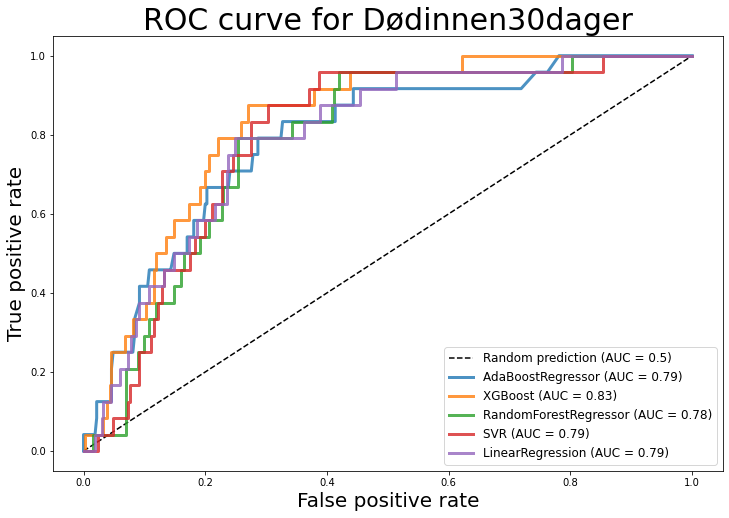

In [109]:

models = {'AdaBoostRegressor':ab, 'XGBoost':xgbr, 'RandomForestRegressor':rf, 'SVR':sv, 
          'LinearRegression':lr, }


plt.figure(figsize=(12,8))
plt.plot([0, 1], [0, 1], c='k',ls = '--', label = 'Random prediction (AUC = 0.5)')

for name, model in models.items():
    model.fit(X_dod, y_dod)
    predictions = model.predict(X_test_dod)
    fpr, tpr, thresholds = roc_curve(y_test_dod, predictions)
    auc = roc_auc_score(y_test_dod, predictions)
    plt.plot(fpr, tpr,  lw=3, label = f'{name} (AUC = {round(auc,2)})', alpha=0.8)


plt.xlabel('False positive rate', size=20)
plt.ylabel('True positive rate', size=20)
plt.title(f'ROC curve for Dødinnen30dager', size =30)
plt.legend(prop={'size': 12}, loc="lower right")
plt.show()

## XGBoost feature importance 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

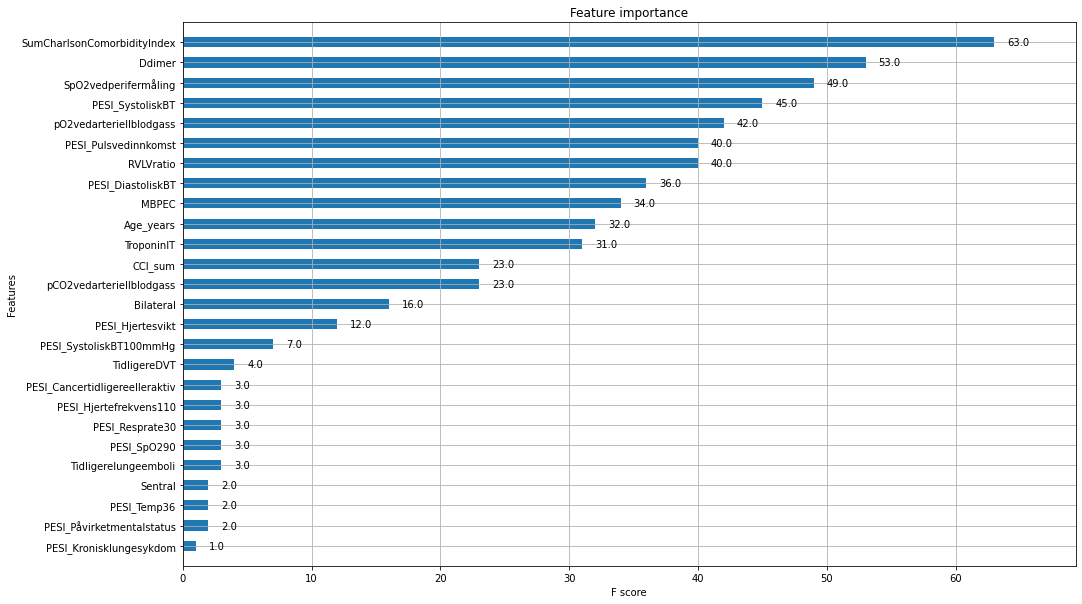

In [110]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
xgb.plot_importance(xgbr, ax=ax, height=0.5)

# ROC curve for ACOinnen30dager

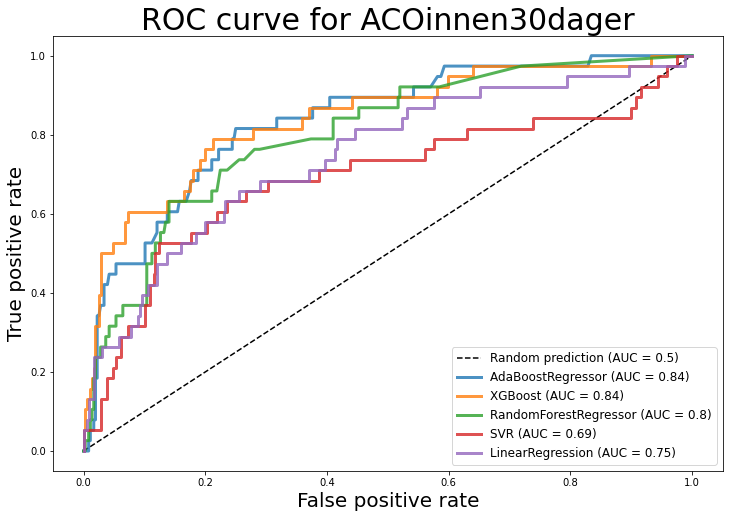

In [115]:
plt.figure(figsize=(12,8))
plt.plot([0, 1], [0, 1], c='k',ls = '--', label = 'Random prediction (AUC = 0.5)')

for name, model in models.items():
    model.fit(X_aco, y_aco)
    predictions = model.predict(X_test_aco)
    fpr, tpr, thresholds = roc_curve(y_test_aco, predictions)
    auc = roc_auc_score(y_test_aco, predictions)
    plt.plot(fpr, tpr,  lw=3, label = f'{name} (AUC = {round(auc,2)})', alpha=0.8)


plt.xlabel('False positive rate', size=20)
plt.ylabel('True positive rate', size=20)
plt.title(f'ROC curve for ACOinnen30dager', size =30)
plt.legend(prop={'size': 12}, loc="lower right")
plt.show()

## XGBoost feature importance 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

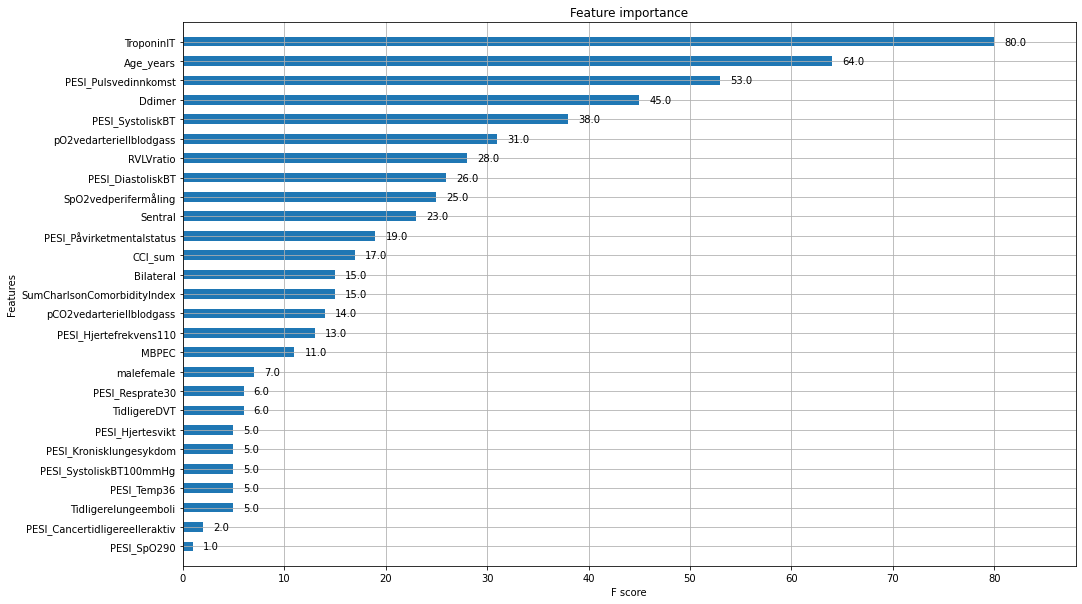

In [112]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
xgb.plot_importance(xgbr, ax=ax, height=0.5)

# ROC curve for Combined_outcome

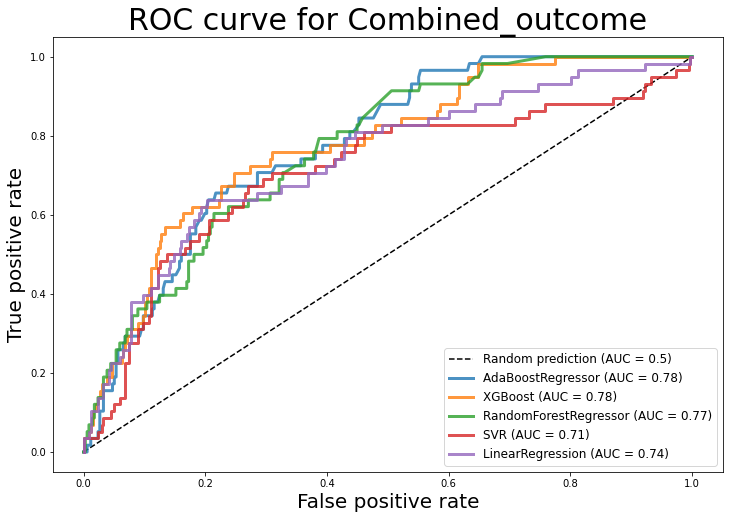

In [113]:
plt.figure(figsize=(12,8))
plt.plot([0, 1], [0, 1], c='k',ls = '--', label = 'Random prediction (AUC = 0.5)')

for name, model in models.items():
    model.fit(X_co, y_co)
    predictions = model.predict(X_test_co)
    fpr, tpr, thresholds = roc_curve(y_test_co, predictions)
    auc = roc_auc_score(y_test_co, predictions)
    plt.plot(fpr, tpr,  lw=3, label = f'{name} (AUC = {round(auc,2)})', alpha=0.8)


plt.xlabel('False positive rate', size=20)
plt.ylabel('True positive rate', size=20)
plt.title(f'ROC curve for Combined_outcome', size =30)
plt.legend(prop={'size': 12}, loc="lower right")
plt.show()

## XGBoost feature importance 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

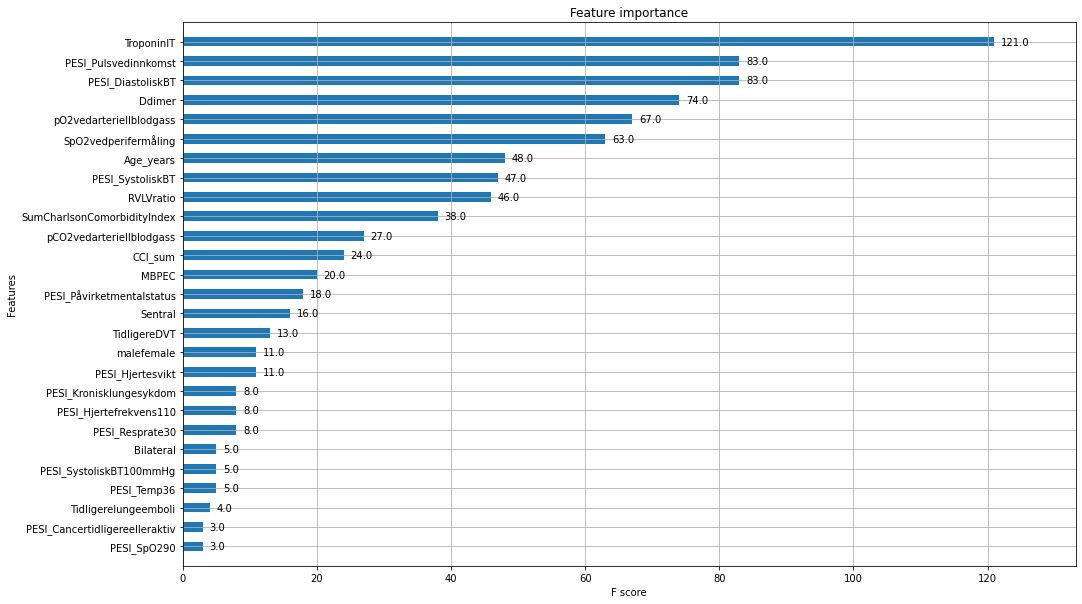

In [114]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
xgb.plot_importance(xgbr, ax=ax, height=0.5)